**Finetuning for Text Classification**

# 6.2 Preparing the dataset

In [2]:
! pip install pathlib


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import requests
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"


def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return


    response = requests.get(url, stream=True, timeout=60)
    response.raise_for_status()
    with open(zip_path, "wb") as out_file:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                out_file.write(chunk)


    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)


    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")


try:
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
except (requests.exceptions.RequestException, TimeoutError) as e:
    print(f"Primary URL failed: {e}. Trying backup URL...")
    url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

sms_spam_collection\SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [4]:

import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [5]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [6]:
def create_balanced_dataset(df):


    num_spam = df[df["Label"] == "spam"].shape[0]


    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)


    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df


balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [7]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

In [8]:
def random_split(df, train_frac, validation_frac):

    df = df.sample(frac=1, random_state=123).reset_index(drop=True)


    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)


    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)


train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

# 6.3 Creating data loaders


In [9]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special = {"<|endoftext|>"}))

[50256]


In [10]:
# ! pip install torch

In [11]:
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
  def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
    self.data = pd.read_csv(csv_file)


    self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

    if max_length is None:
       self.max_length = self._longest_encoded_length()

    else :
      self.max_length = max_length
      self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

    self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

  def __getitem__(self, index ):
    encoded= self.encoded_texts[index]
    label = self.data.iloc[index]["Label"]
    return(
        torch.tensor(encoded, dtype = torch.long),
        torch.tensor(label, dtype = torch.long)
    )

  def __len__(self):
    return len(self.data)

  def _longest_encoded_length(self):
    max_length =0
    for encoded_text in self.encoded_texts:
      encoded_length = len(encoded_text)
      if encoded_length > max_length:
          max_length = encoded_length
    return max_length


#   shortest way to find the longest one is written below
  # return max(len(encoded_text) for encoded_text in self.encoded_texts)


In [12]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)
print(train_dataset.max_length)


120


In [13]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [14]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [15]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

    print("Input batch dimensions:", input_batch.shape)
    print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])
Input batch dimensions: torch.Size([8, 120])
Label batch dimen

In [16]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


# 6.4 Initializing a model with the pretrained weights

In [17]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [18]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

In [19]:
from previous_chapters import (
    generate_text_simple,
    text_to_token_ids,
    token_ids_to_text
)

text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


In [20]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


# 6.5 Adding the classification Head

In [21]:
print (model);

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

In [22]:
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

In [23]:
for param in model.trf_blocks[-1].parameters():
  param.requires_grad =True

for param in model.final_norm.parameters():
  param.requires_grad = True

In [24]:
inputs = tokenizer.encode("Do you have time ")
inputs = torch.tensor(inputs).unsqueeze(0)
print("inputs:", inputs)
print("Inputs dimensions : ", inputs.shape )

inputs: tensor([[5211,  345,  423,  640,  220]])
Inputs dimensions :  torch.Size([1, 5])


In [25]:
with torch.no_grad():
  outputs = model(inputs)

In [26]:
print(outputs)

tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902],
         [-2.8445,  4.2495]]])


In [27]:
outputs[:, -1 , :]

tensor([[-2.8445,  4.2495]])

# 6.6 Calculating the classsification accuracy and loss

In [28]:
logits = outputs[: , -1,:]
probas = torch.softmax(logits , dim =-1)
print( probas)

tensor([[8.2934e-04, 9.9917e-01]])


In [29]:
label = torch.argmax(probas).item()
label

1

In [30]:
label = torch.argmax(logits ).item ()
label

1

In [31]:
target = torch.tensor([1, 0,1,0, 1 ])
pred = torch.tensor([1, 0,1,0,0])

(target==pred).sum().item()/target.shape[0]

0.8

In [32]:
def calc_accuracy_loader(data_loader , model , device , num_batches = None ):
    model.eval()
    correct_prediction , num_examples = 0,0

    if num_batches is None :
      num_batches = len(data_loader)
    else :
      num_batches = min (num_batches, len(data_loader ))

    for i, (input_batch , target_batch ) in enumerate(data_loader):
        if i < num_batches:
          input_batch, target_batch = input_batch.to(device), target_batch.to(device)
          with torch.no_grad():
              logits = model(input_batch)[:, -1, :]
          predicted_labels = torch.argmax(logits , dim = -1 )

          num_examples += predicted_labels.shape[0]
          correct_prediction +=( predicted_labels == target_batch).sum().item()

        else:
            break
    return  correct_prediction/num_examples



In [33]:
import torch
print(torch.__file__)
print(torch.__version__)


C:\Users\HP\PycharmProjects\Computervision_advanced\.venv1\lib\site-packages\torch\__init__.py
2.5.1+cu121


In [34]:
# !python -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


In [35]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)



cuda


In [36]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.version.cuda)


True
1
12.1


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)



cuda


In [38]:
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader , model , device, num_batches = 10)
print(train_accuracy*100 )

46.25


In [39]:
torch.manual_seed(123)
val_accuracy = calc_accuracy_loader(val_loader , model , device, num_batches = 10)
print(val_accuracy*100 )

45.0


In [40]:
torch.manual_seed(123)
test_accuracy = calc_accuracy_loader(test_loader , model , device, num_batches = 10)
print(test_accuracy*100 )

48.75


In [41]:
def calc_loss_batch(input_batch, target_batch, model, device ):
  input_batch , target_batch=  input_batch.to(device), target_batch.to(device )
  logits = model(input_batch)[:, -1, :]
  loss = torch.nn.functional.cross_entropy(logits, target_batch)
  return loss


In [42]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    model.eval()
    total_loss = 0
    if len(data_loader)== 0:
      return float("nan")

    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i , ( input_batch , target_batch) in enumerate (data_loader):
        if i < num_batches:
          loss = calc_loss_batch(input_batch, target_batch, model, device)
          total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [43]:
train_loss = calc_loss_loader(train_loader, model, device, num_batches =10)
print(train_loss)

2.633044493198395


In [44]:
val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
print(val_loss)

2.5829511404037477


In [45]:
test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)
print(test_loss)

2.321962332725525


# 6.7 Finetuning the model on supervised data

In [46]:
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            # print(input_batch.device)

            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()

            examples_seen += input_batch.shape[0]
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(
                    f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}"
                )

        train_accuracy = calc_accuracy_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_accuracy = calc_accuracy_loader(
            val_loader, model, device, num_batches=eval_iter
        )

        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")

        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen


In [47]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [48]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

cpu
Ep 1 (Step 000000): Train loss 2.884, Val loss 2.596
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
Ep 1 (Step 000050): Train loss 0.293, Val loss 0.190
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
Ep 1 (Step 000100): Train loss 0.148, Val loss 0.501
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
Training accuracy: 97.50% | Validation accuracy: 95.00%
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
Ep 2 (Step 000150): Train loss 0.162, Val loss 0.073
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu


In [49]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

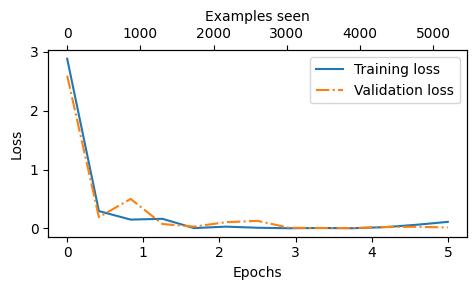

In [50]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

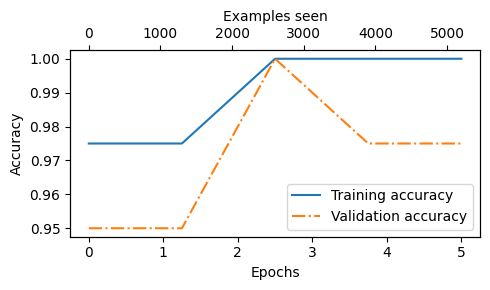

In [51]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [52]:

train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 99.62%
Validation accuracy: 97.99%
Test accuracy: 96.67%


# 6.8 Using the LLM as a spam classifier

In [56]:
def classify_text(text, model, tokenizer, device, max_length= None, pad_token_id= 50256):
    inputs_ids= tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]
    inputs_ids= inputs_ids[:min(max_length , supported_context_length)]
    inputs_ids += [pad_token_id] *( max_length - len(inputs_ids))
    inputs_ids = torch.tensor(inputs_ids, device = device ).unsqueeze(0)

    with torch.no_grad():
        logits = model(inputs_ids )[:, -1 , :]
    predicted_label = torch.argmax(logits , dim = -1 ).item()

    return"spam" if predicted_label ==1  else "not_spam"

In [57]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_text(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [58]:

text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_text(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not_spam


In [59]:
torch.save(model.state_dict(), "review_classifier.pth")

In [60]:
model_state_dict = torch.load("review_classifier.pth", map_location=device, weights_only=True)
model.load_state_dict(model_state_dict)

<All keys matched successfully>